# Storms n Stocks

Our project aims to ....



In [4]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 455.7 kB/s eta 0:00:0000:0100:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


## Dataset Building

The following sections of code demonstrate the methodology we used for building our dataset. The whole process took around 72 hours.

In [1]:
BUILD_DATASET = False

In [ ]:
import os
from utils.dataset.build import DatasetBuilder
from utils.dataset.labels import LabelsBuilder


if BUILD_DATASET:
    disasters = ["earthquake", "flood", "hurricane", "wildfire", "tsunami", "landslide", "volcano", "tornado", "drought",
                "explosion", "fires", "terrorist attack", "plane crash", "train derailment", "oil spill", "building collapse",
                "nuclear accident", "pandemic", "cyber attack", "stock market crash", "power outage", "riots", "protest"]

    countries = ["US", "CH", "TW", "GM", "FR", "UK", "JA", "KS", "IN", "BR"]

    output_dir = os.path.join("data", "news", "links")
    os.makedirs(output_dir, exist_ok=True)

    builder = DatasetBuilder(disasters, countries, output_dir)

    builder.build_news_urls_dataset()
    builder.download_articles(batch_size=500)

    labels = LabelsBuilder()
    labels.build_labels()

## Loading Dataset

In [1]:
import os
from utils.dataset.articles import ArticlesDataset


DATA_DIR = os.path.join("data", "articles")

dataset = ArticlesDataset(DATA_DIR)
print(f"Dataset size: {len(dataset)}")
articles = dataset.filter_by_label(event_occured=True)
print(f"Articles mentioning disaster occuring: {len(articles)}")

Dataset size: 56628
Articles mentioning disaster occuring: 25164


## Dataset Exploration (Ground Truth)

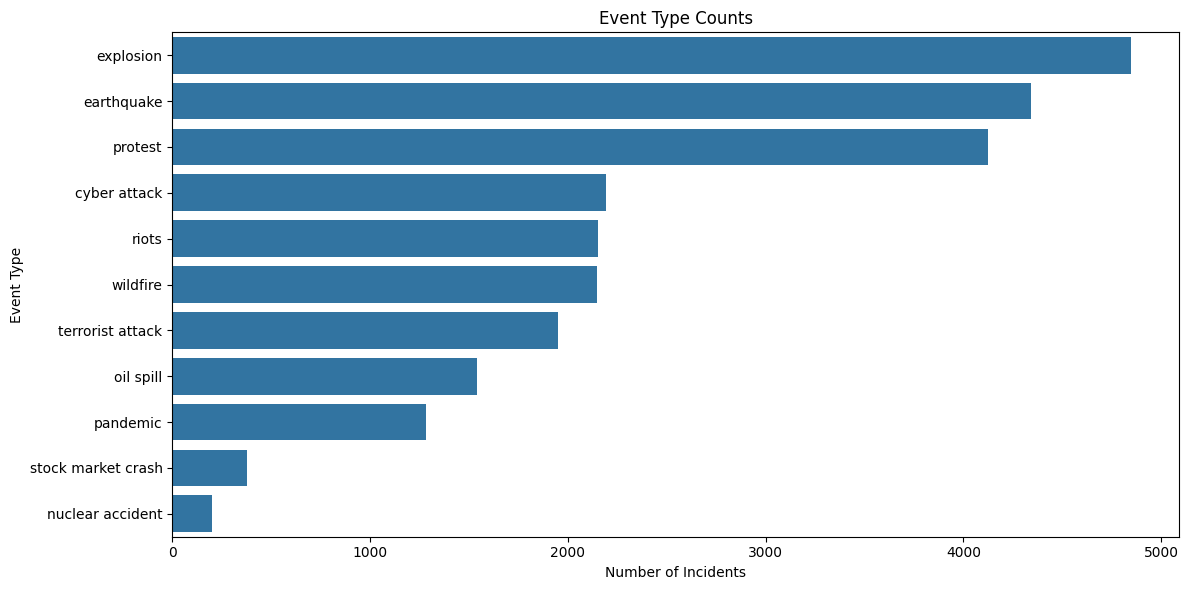

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
sns.countplot(data=articles.filtered_labels, y="event", order=articles.filtered_labels["event"].value_counts().index)
plt.title("Event Type Counts")
plt.xlabel("Number of Incidents")
plt.ylabel("Event Type")
plt.tight_layout()

In [31]:
import folium
from folium.plugins import HeatMap

map_ = folium.Map(location=[20,0], zoom_start=2)
heat_data = articles.filtered_labels[['latitude','longitude','impact']].dropna().values.tolist()
HeatMap(heat_data, radius=8, blur=5, max_zoom=10).add_to(map_)
map_

## Deduplication

In [ ]:
import pandas as pd
from utils.deduplication.deduplicate import Deduplicator


records_df = articles.filtered_labels
deduplicator = Deduplicator(records_df)
deduplicator.deduplicate(spatial_radius=100, temporal_radius=3)
confident_events = deduplicator.get_unique_events(confidence_threshold=0.7)
confident_events

/home/shivansh/projects/sb-ghvcs/NUS/cs5246-text-mining-proj/utils/deduplication/deduplicate.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df["dt"] = pd.to_datetime(self.df["dt"], format="%Y-%m-%d", errors="coerce")
/home/shivansh/projects/sb-ghvcs/NUS/cs5246-text-mining-proj/utils/deduplication/deduplicate.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['loc_cluster'] = spatial_cluster.fit_predict(coords)


,event_id,event,dt,impact,latitude,longitude,city,state,country,confidence,n_reports
103,cyber attack_0_43,cyber attack,2020-11-25,5,39.464767,-76.733652,None,Maryland,United States,0.778,6
105,cyber attack_0_45,cyber attack,2021-01-01,3,30.056440,-90.566681,Reserve,Louisiana,United States,0.720,3
150,cyber attack_0_86,cyber attack,2022-08-26,2,43.193852,-71.572395,None,New Hampshire,United States,0.760,4
161,cyber attack_0_96,cyber attack,2023-01-09,3,41.589614,-93.616396,Des Moines,Iowa,United States,0.792,5
165,cyber attack_101_0,cyber attack,2021-07-22,4,-30.559482,22.937506,None,None,South Africa,0.888,8
...,...,...,...,...,...,...,...,...,...,...,...
7653,wildfire_9_83,wildfire,2024-06-01,4,38.794595,-106.534838,None,None,United States,0.720,3
7656,wildfire_9_86,wildfire,2024-06-24,4,38.794595,-106.534838,None,None,United States,0.770,8
7663,wildfire_9_92,wildfire,2024-11-16,3,38.794595,-106.534838,None,None,United States,0.869,9
7667,wildfire_9_96,wildfire,2025-01-07,5,38.794595,-106.534838,None,None,United States,0.903,10


## Stocks Correlation

100%|██████████| 49/49 [01:42<00:00,  2.08s/it]


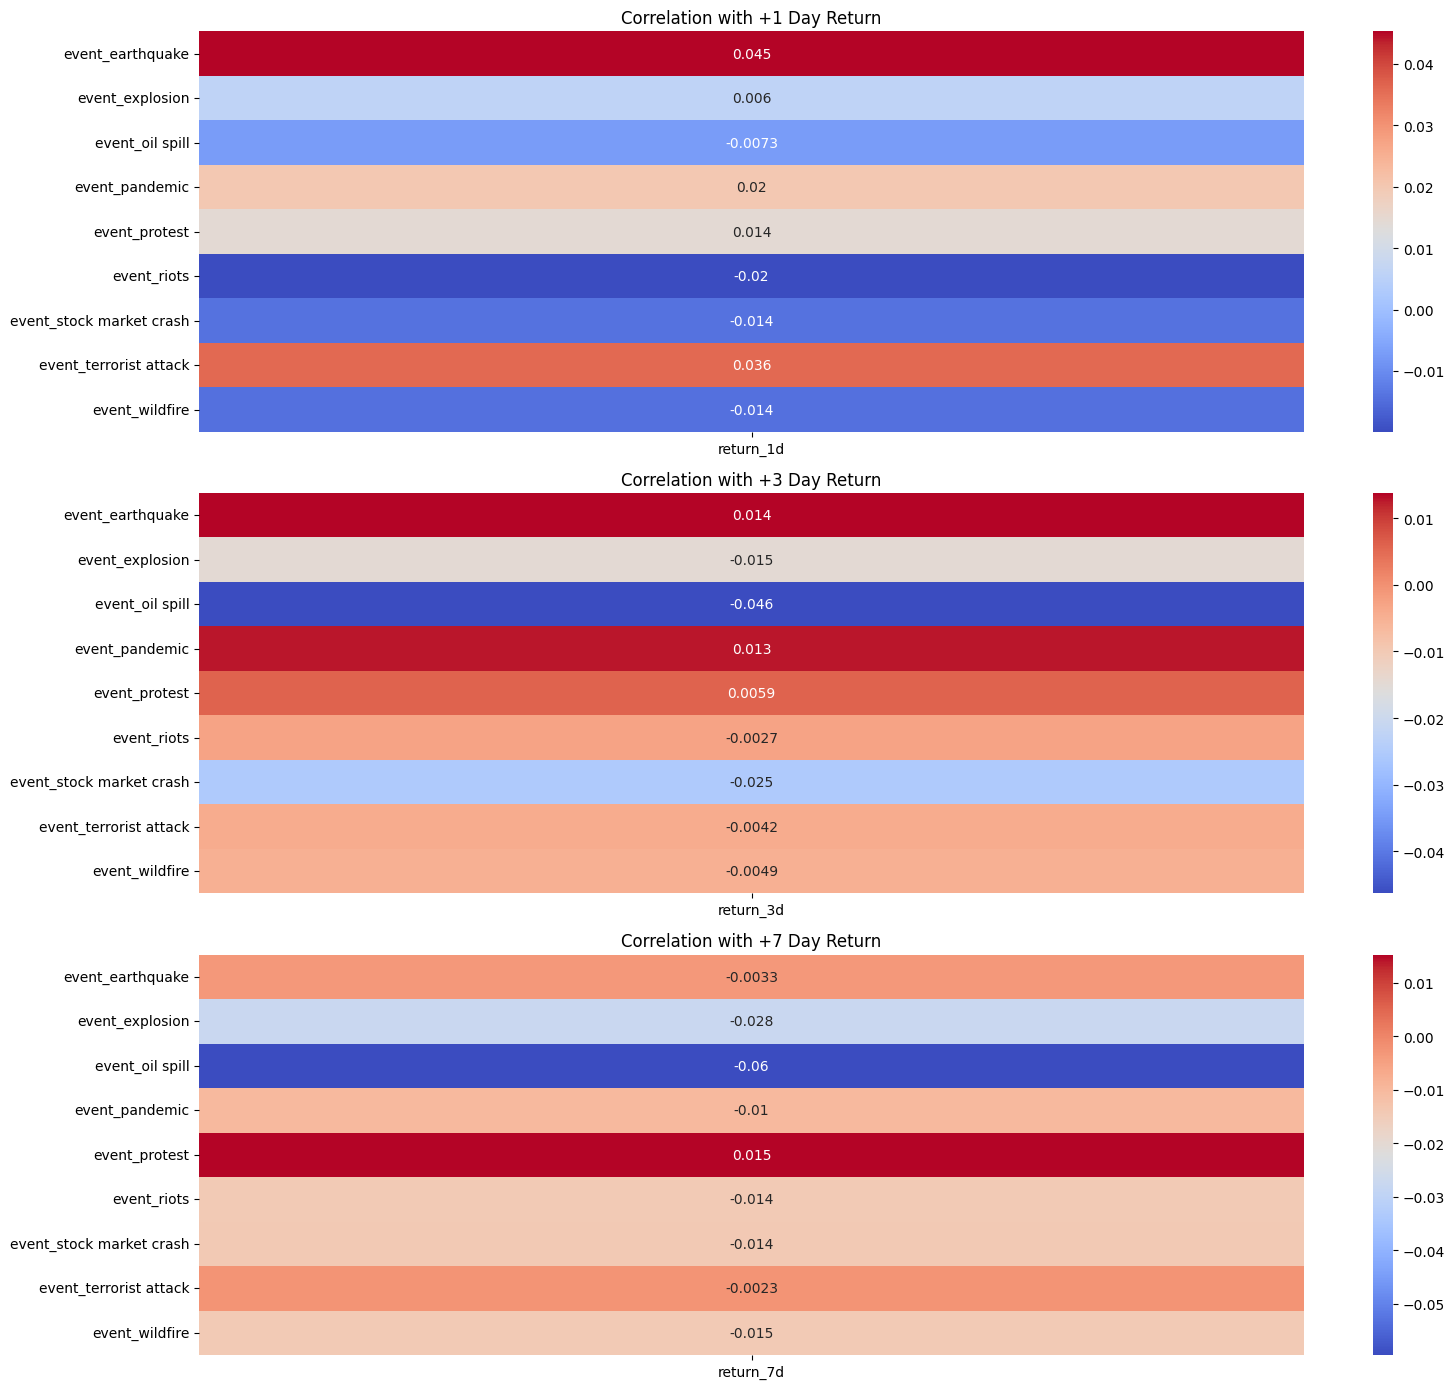

In [ ]:
from utils.stocks.correlation import StocksCorrelation


stocks_correlation = StocksCorrelation(confident_events)
cor_1d, cor_3d, cor_7d = stocks_correlation.compute_correlation()

plt.figure(figsize=(16, 14))
plt.subplot(3, 1, 1)
sns.heatmap(cor_1d, annot=True, cmap='coolwarm')
plt.title("Correlation with +1 Day Return")

plt.subplot(3, 1, 2)
sns.heatmap(cor_3d, annot=True, cmap='coolwarm')
plt.title("Correlation with +3 Day Return")

plt.subplot(3, 1, 3)
sns.heatmap(cor_7d, annot=True, cmap='coolwarm')
plt.title("Correlation with +7 Day Return")

plt.tight_layout()
plt.show()

## Disaster Classification

In [ ]:
from utils.disaster_classification.classify import DisasterClassifier


classifier = DisasterClassifier(dataset, k_fold=5)
train_losses, train_accuracies, val_losses, val_accuracies = classifier.train()

## Event Extraction

In [2]:
from utils.event_extraction.lda import LDA


lda = LDA(articles)
lda.build_model()
lda.df
# lda.generate_topic_labels_from_top2()

[nltk_data] Downloading package punkt to /home/shivansh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/shivansh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shivansh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/shivansh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Pre-processing dataset...


Building corpus: 100%|██████████| 25164/25164 [00:00<00:00, 102734.45it/s]


Loaded LDA Model
Running inference...


Running inference: 100%|██████████| 25164/25164 [00:02<00:00, 9004.25it/s]


,index_id,title,event,tokens,extracted_event
0,1,Evacuation Orders in Place Amid Massive South ...,wildfire,"[evacuation, orders, place, amid, massive, sou...",8
1,2,Wildfires prompt evacuations in Cumberland Cou...,wildfire,"[wildfires, prompt, evacuations, cumberland, c...",8
2,3,Active NC wildfires burning 600 acres in four ...,wildfire,"[active, wildfires, burning, 600, acres, four,...",8
3,7,Wildfire burns at Wharton State Forest in Sout...,wildfire,"[wildfire, burns, wharton, state, forest, sout...",8
4,11,Safety tips as smoky conditions persist near C...,wildfire,"[safety, tips, smoky, conditions, persist, nea...",8
...,...,...,...,...,...
25159,56606,How to check and protect your information online,cyber attack,"[check, protect, information, online]",1
25160,56616,Marriott to rename loyalty program after cyber...,cyber attack,"[marriott, rename, loyalty, program, cyber, at...",1
25161,56618,National Guard called in after city of Akron t...,cyber attack,"[national, guard, called, city, akron, targete...",1
25162,56619,"Dems allege they were hacked , likely by Russi...",cyber attack,"[dems, allege, hacked, likely, russian, intel,...",8


In [3]:
lda.generate_topic_labels()

Generating topics...


{0: 'protest (0.09), protests (0.03), protesters (0.03), trump (0.02), police (0.02)',
 1: 'attack (0.10), cyber (0.05), iran (0.02), terrorist (0.02), says (0.01)',
 2: 'quake (0.07), riots (0.05), capitol (0.02), data (0.02), government (0.02)',
 3: 'pandemic (0.04), covid (0.04), china (0.02), years (0.02), india (0.02)',
 4: 'explosion (0.12), killed (0.02), injured (0.02), dead (0.02), gas (0.02)',
 5: 'alaska (0.03), big (0.03), newsradio (0.02), crisis (0.02), facility (0.02)',
 6: 'com (0.02), car (0.02), hong (0.02), kong (0.01), may (0.01)',
 7: 'new (0.07), coronavirus (0.04), area (0.03), shakes (0.03), san (0.02)',
 8: 'oil (0.04), spill (0.03), fire (0.03), county (0.03), wildfire (0.03)',
 9: 'earthquake (0.21), magnitude (0.12), reported (0.06), near (0.06), news (0.05)'}

## Location Extraction

In [ ]:
from utils.location_extraction.extract import LocationExtractor


extractor = LocationExtractor(articles)
city_accuracy, state_accuracy, country_accuracy = extractor.build()
print(f"\tCity Accuracy: {city_accuracy}\n\tState Accuracy: {state_accuracy}\n\tCountry Accuracy: {country_accuracy}")

Building dataframe...


Extracting locations:   0%|          | 100/25164 [00:09<41:21, 10.10it/s]  


(0.27, 0.39, 0.58)

## Date Extraction

In [25]:
from utils.date_extraction.extract import DateExtractor

extractor = DateExtractor(articles)
extractor.extract_date_entities()
accuracy = extractor.extract_dates()
print(f"Accuracy: {accuracy*100:.2f}%")

Loaded 25164 articles
Building candidate date entities
Loaded saved candidates
Loaded saved extracted dates
Accuracy: 20.85%


In [26]:
extractor.articles_df

,index_id,title,date,country,query,dt_label,impact_label,content,content_preprocessed,dates_content,dates_title,extracted_date
0,1,Evacuation Orders in Place Amid Massive South ...,2025-03-02,US,wildfire,2025-03-02,4,"Based on facts, either observed and verified f...",Based facts observed verified firsthand report...,"['Sunday', 'February', 'February 27', '2025', ...",[],2025-03-01
1,2,Wildfires prompt evacuations in Cumberland Cou...,2025-03-05,US,wildfire,2025-03-04,4,Wildfires have broken out in Middle Tennessee ...,Wildfires broken Middle Tennessee following se...,"['March 5', 'March 5', 'Tuesday', 'March 5']",[],2025-03-05
2,3,Active NC wildfires burning 600 acres in four ...,2025-03-02,US,wildfire,2025-03-02,3,"RALEIGH, N.C. (WNCN) — In addition to a 400+ a...",RALEIGH N.C. WNCN addition 400 + acre wildfire...,"['weekend', 'Sunday', 'Sunday', 'Saturday', 'S...",[],2025-03-01
3,7,Wildfire burns at Wharton State Forest in Sout...,2025-03-22,US,wildfire,2025-03-21,4,Crews are still battling a wildfire in souther...,Crews battling wildfire southern New Jersey st...,"['Saturday', 'Sunday', 'March 23']",[],2025-03-15
4,11,Safety tips as smoky conditions persist near C...,2025-03-03,US,wildfire,2025-03-01,3,from the ongoing fires may be noticed in certa...,ongoing fires noticed certain areas dealing sm...,"['weekend', 'Sunday']",[],2025-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...
25159,56606,How to check and protect your information online,2019-01-22,US,cyber attack,2019-01-20,3,After Macon-Bibb County sites were hacked over...,Macon Bibb County sites hacked weekend ways in...,"['Sunday', 'day', 'annually']",[],2019-01-19
25160,56616,Marriott to rename loyalty program after cyber...,2019-01-16,US,cyber attack,2019-01-16,5,Jan 16 (Reuters) - Marriott International Inc ...,Jan 16 Reuters Marriott International Inc rela...,"['Jan 16', 'Wednesday', 'Feb. 13', 'earlier mo...",[],2019-01-16
25161,56618,National Guard called in after city of Akron t...,2019-01-25,US,cyber attack,2019-01-22,3,The incident is currently under investigation....,incident currently investigation members Ohio ...,['past Tuesday'],[],2019-01-25
25162,56619,"Dems allege they were hacked , likely by Russi...",2019-01-18,US,cyber attack,2018-11-14,2,The Democratic National Committee (DNC) claims...,Democratic National Committee DNC claims targe...,"['November', 'Thursday', 'November 14 2018', '...",['2018'],2019-01-17


## Severity Extraction

In [2]:
from utils.severity_extraction.extract import SeverityExtractor

extractor = SeverityExtractor(articles)

[nltk_data] Downloading package punkt to /home/shivansh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/shivansh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/shivansh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /home/shivansh/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


Loaded 25164 articles. Preprocessing...


### Severity as Sentiment Analysis

In [12]:
from sklearn.metrics import classification_report, accuracy_score


y_test, y_pred = extractor.vader_sentiment()
print(classification_report(y_test, y_pred, zero_division=True))
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.4f}%")

Running Sentiment Analysis


100%|██████████| 25164/25164 [02:45<00:00, 151.83it/s]

              precision    recall  f1-score   support

           0       0.02      0.43      0.04       262
           1       1.00      0.00      0.00      3018
           2       0.15      0.08      0.11      3307
           3       0.27      0.03      0.06      5800
           4       0.19      0.06      0.09      5996
           5       0.32      0.71      0.44      6781

    accuracy                           0.23     25164
   macro avg       0.33      0.22      0.12     25164
weighted avg       0.33      0.23      0.17     25164

Accuracy: 22.8104%


### ML Methods for Severity Estimation

#### Naive Bayes Classifier

In [11]:
from sklearn.metrics import classification_report, accuracy_score


y_test, y_pred = extractor.naive_bayes()
print(classification_report(y_test, y_pred, zero_division=True))
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.4f}%")

Training Naive Bayes Classifier
Loaded test and train vectors
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        79
           1       0.46      0.54      0.50       905
           2       0.38      0.12      0.19       992
           3       0.38      0.41      0.39      1740
           4       0.45      0.37      0.40      1799
           5       0.52      0.71      0.60      2035

    accuracy                           0.45      7550
   macro avg       0.53      0.36      0.35      7550
weighted avg       0.45      0.45      0.43      7550

Accuracy: 45.4834%


#### Logistic Regression Classifier

In [14]:
from sklearn.metrics import classification_report


y_test, y_pred = extractor.logistic_regression()
print(classification_report(y_test, y_pred, zero_division=True))
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.4f}%")

Training Logistic Regression Classifier
Loaded test and train vectors
              precision    recall  f1-score   support

           0       0.03      0.61      0.05        79
           1       0.44      0.53      0.48       905
           2       0.21      0.12      0.15       992
           3       0.25      0.01      0.03      1740
           4       0.33      0.08      0.13      1799
           5       0.38      0.68      0.49      2035

    accuracy                           0.29      7550
   macro avg       0.27      0.34      0.22      7550
weighted avg       0.32      0.29      0.25      7550

Accuracy: 29.0861%


/home/shivansh/projects/sb-ghvcs/NUS/cs5246-text-mining-proj/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Random Forest Classifier

In [13]:
from sklearn.metrics import classification_report


y_test, y_pred = extractor.random_forest()
print(classification_report(y_test, y_pred, zero_division=True))
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.4f}%")

Training Random Forest Classifier
Loaded test and train vectors
              precision    recall  f1-score   support

           0       0.11      0.24      0.16        79
           1       0.68      0.59      0.63       905
           2       0.65      0.25      0.36       992
           3       0.47      0.50      0.48      1740
           4       0.54      0.42      0.47      1799
           5       0.56      0.81      0.66      2035

    accuracy                           0.54      7550
   macro avg       0.50      0.47      0.46      7550
weighted avg       0.55      0.54      0.53      7550

Accuracy: 54.0265%
